In [1]:
import burst_detection as bd

from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore

import logging
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import spacy
from tqdm import tqdm

In [2]:
#settings
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
pd.set_option('display.max_colwidth', -1) #show full columns

figures_path = '../ms/figures/'
data_path = '../data/processed/'

nlp = spacy.load("nl_core_news_sm", disable=["ner"]) #load spacy NLP

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
#sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

In [3]:
#set stopwords and load custom dutch dictionary, for optional dictionary matching

with open('../data/nl_dictionary.pkl', 'rb') as f:
    dictionary_nl = pickle.load(f)

stop_words = list(set(stopwords.words('dutch')))

extra_stop_words = ['xcxbb','xcxa', 'xcxab', 'xexxa', 'xexxaxexxa', 'xexx', 'xexxaxexxaxexxa',
                    'xcx', 'xexxe', 'xexxaxexxaxexxaxexxa', 'xcxaf', 'xcxb', 'xcxbc', 'xcxaxcxan',
                     'xexxaxexxaxexxaxexxaxexxa', 'xexxaxcxbb', 'xexxxexx', 'xcxc', 'xcxabxexxa',
                     'xexxxexxa', 'xcxaxexxa', 'xexxaxcxa', 'xcxbbxexxa', 'xexxaxcxab', 'xcxaxcxa',
                    'xexxaxexx', 'xcxabxcxbb', 'xcxbbxcxbb', 'xcxabi', 'xcxabn', 'xcxabxcxab', 'bel', 'inl',
                    'xexxexexxe', 'xcxbxcxbk', 'xcxan', 'xexxxexxxexx', 'den', 'sigaretten', 'sigaret', 
                    'advertentie', 'ingezonden', 'per', 'alle', 'onze', 'ter', 'wel', 'weer', 'geef',
                   'koop', 'tel', 'kunt', 'the','wij', 'lil', 'doe']

stop_words.extend(extra_stop_words)

In [4]:
def word_proportions(df, word_list, freq):
    all_r = pd.DataFrame(columns=word_list, index=d.index)
    for i, word in enumerate(word_list):
        all_r[word] = pd.concat([df.loc[:, time_frame],
                                df['words'].apply(lambda x: word in x)], axis=1) \
                               .groupby(by=time_frame).sum().reset_index(drop=True)
        if np.mod(i, 100)==0:
            print('total words', len(word_list), 'word', i, 'complete')
    return all_r

def find_bursts(d, all_r, word_list):
    '''
    burst detection function
    '''
    s = 2  #resolution of state jumps; higher s --> fewer but stronger bursts
    gam = 0.5 #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
    n = len(d) #number of timepoints
    smooth_win = 5
    
    all_bursts = pd.DataFrame(columns=['begin', 'end', 'weight'])
    
    for i, word, in enumerate(word_list):
        r = all_r.loc[:, word].astype(int)
        
        #find the optimal state sequence (using the Viterbi algorithm)
        [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win)
        
        #enumerate the bursts
        bursts = bd.enumerate_bursts(q, word)
        
        #find weights of each burst
        bursts_weighted = bd.burst_weights(bursts, r, d, p)
        
        #add the weighted burst to list of all bursts
        all_bursts = all_bursts.append(bursts_weighted, ignore_index=True)
        
        #print a progress report every 100 words
        if np.mod(i,100)==0:
            print('total words', len(word_list), 'word',i,'complete')
    
    return all_bursts.sort_values(by='weight', ascending=False)
    
    
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc), min_len=3) if word not in stop_words] for doc in texts]
    
    
def check_dictionary(texts):
    return [[word for word in simple_preprocess(str(doc)) if word in dictionary_nl] for doc in texts]
    

def visualize_bursts(n_bursts, bursts, r, title):
    n = len(d) 
    top_bursts = bursts.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]
    #sort bursts by end date
    sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
    #for burst that end at the last timepoint, sort by start
    last_timepoint = np.max(sorted_bursts['end'])
    sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)
    
    heatmap_data = r.loc[:,set(sorted_bursts['label'])]
    
    #find the baseline proportions sum(r)/sum(d) for each label
    baseline_p = heatmap_data.sum(axis=0) / d.sum()

    #convert r values into proportions at each timepoint
    heatmap_data = heatmap_data.apply(lambda x: x/d)

    #sort the rows according to the order used in the timeline
    order = sorted_bursts['label'].drop_duplicates(keep='last').values
    
    #transpose data and reindex the data according to the sorted word order
    heatmap_data = heatmap_data.T.reindex(order)

    #optional: convert proportions into multiples of the baseline proportion
    heatmap_data = heatmap_data.apply(lambda x: x/baseline_p[x.index])

    #smooth proportions with the same smoothing window used in burst detection
    smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

    #create the heatmap
    plt.figure(figsize=(10,30))
    ax = sns.heatmap(smoothed_heatmap_data[::-1], vmin=0, vmax=2.5, cmap=blue_cmap, yticklabels=True,
                 cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.05, shrink=0.7))
    plt.title('Normalized proportions of "bursting" ' + title + ' words over time')
    plt.xticks(range(0,n,24), range(1945,1995,2), rotation='vertical')

    #create boxes around bursting periods
    for index, burst in sorted_bursts.iterrows():
        
        #define outline positions
        y = smoothed_heatmap_data.index.get_loc(burst['label'])
        y = len(smoothed_heatmap_data) - y - 1 #reverse since it counts from bottom
        xstart = burst['begin'] 
        width = burst['end'] - burst['begin'] + 1
    
        #draw rectangle
        ax.add_patch(plt.Rectangle((xstart,y), width, height=1, alpha=1, 
                           facecolor='none', edgecolor='k', linewidth=1))
    plt.savefig(title + "_heatmap.png", bbox_inches="tight", dpi=300)

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    print('lemmatizing!')
    nlp = spacy.load('nl_core_news_sm', disable=['parser', 'ner'])
    text_clean = []
    for sent in tqdm(texts):
        doc = nlp(sent)
        text_clean.append(' '.join([str(token) for token in doc if token.pos_ in allowed_postags]))
    return text_clean

def nmf_topic_modeling(docs, n_top_words):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=200, stop_words=stop_words)
    dtm = tfidf_vectorizer.fit_transform(docs)
    vocab = tfidf_vectorizer.get_feature_names()
    print("number of words: {}".format(len(vocab)))
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd', verbose=0, max_iter=500)
    doctopic = nmf.fit_transform(dtm)
    topic_words = []
    topic_summaries = []
    for topic in nmf.components_:
        word_idx = np.argsort(topic)[::-1][0:n_top_words]
        topic_words.append([vocab[i] for i in word_idx])
    for t in range(len(topic_words)):
#         print("Topic {}: {}".format(t, ' '.join(topic_words[t][:n_top_words])))
        topic_summaries.append("Topic {}: {}".format(t, ' '.join(topic_words[t][:n_top_words])))
    return doctopic, topic_words, topic_summaries


# Read Corpus

In [5]:
df = pd.read_csv(os.path.join(data_path,'cigarette_corpus.tsv'))
df['words'] = df['ocr'].apply(lambda x: x.lower().split())
df['date'] = pd.to_datetime(df['date'])
df['publication_year'] = df['date'].apply(lambda x: x.year)
df['publication_month'] = df['date'].apply(lambda x: x.month)
df['publication_day'] = df['date'].apply(lambda x: x.day)

drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'image_url']
df.drop(drop_cols, axis=1, inplace=True)

corpus = np.array(df['ocr'])

In [6]:
corpus_clean = lemmatization(corpus)

lemmatizing!


100%|██████████| 43781/43781 [13:04<00:00, 55.78it/s] 


In [49]:
# corpus_clean2 = []
# for doc in corpus_clean:
#     corpus_clean2.append(' '.join([str(token) for token in doc]))

We use TF-DF to extract distinctive words from the corpus. Other options could be LDA or NMF, and then select top words in topics. 

In [7]:
#maximum number of distinctive words
max_number_words = 500

# TF-IDF

In [ ]:
# ngram_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), max_df=0.8, min_df=200)
# X = ngram_vectorizer.fit_transform(df['ocr'])
# vocab = list(ngram_vectorizer.get_feature_names())
# counts = X.sum(axis=0).A1
# freq_distribution = Counter(dict(zip(vocab, counts)))

In [8]:
vectorizer = TfidfVectorizer(norm='l1', sublinear_tf=True, analyzer='word', ngram_range=(1,1),
                                   stop_words=stop_words, lowercase=True, max_df = 0.8, min_df = 100)
tfidf_matrix =  vectorizer.fit_transform(corpus_clean)
scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
feature_list = []
tf_idf_words = []
for item in sorted_scores:
    if item[1] >= 15 and len(item[0]) > 2 and item[0] in dictionary_nl:
        feature_list.append({'word': item[0], 'score': item[1]})
        tf_idf_words.append(item[0])
features = pd.DataFrame(feature_list)
features.head(20)
tf_idf_words = tf_idf_words[:max_number_words]

# NMF
This is optional and not included in the article

In [69]:

# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from nltk.corpus import stopwords

n_features = 10000
n_topic_words = 150
n_components = 15 #number of topics

doctopic, topic_words, topic_summaries = nmf_topic_modeling(corpus, n_topic_words)

nmf_words = []
for topic in topic_words:
    for word in topic:
        if len(word) > 2: #TODO LIST COMPREHENSION
            if word not in nmf_words:
                #if word in dictionary_nl: #for dictionary matching, uncomment
                    nmf_words.append(word)
nmf_words = nmf_words[:max_number_words]

number of words: 3077


# LDA
This is optional and not included in the article

In [76]:
docs = [d.split() for d in corpus]
docs = remove_stopwords(docs)
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=200, no_above=.8) #very strict pruning similar to tf-idf pruning

# print('matching dictionary')
# del_ids = [k for k, v in dictionary.items() if v not in dictionary_nl]
# dictionary.filter_tokens(bad_ids=del_ids)

corpus_lda = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))



# Training params
passes = 5
iterations = 1000
#eval_every = 5  # Skip evaluating model perplexity


%time model = LdaModel(corpus=corpus_lda, id2word=dictionary, alpha='auto', eta='auto', iterations=iterations, num_topics=n_components,passes=passes)
#%time model = LdaMulticore(corpus=corpus_lda, id2word=dictionary, eta='auto', workers=cpu_count()-1, iterations=iterations, num_topics= n_components, passes=passes)

topic_words = []
for i in range(num_topics):
    tt = model.get_topic_terms(i, n_topic_words)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    lda_words = []
    for topic in topic_words:
        for word in topic:
                if word not in lda_words:
                    lda_words.append(word)

lda_words = lda_words[:max_number_words]

2020-04-13 09:40:12,086 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-04-13 09:40:13,690 : INFO : adding document #10000 to Dictionary(289990 unique tokens: ['biedt', 'cent', 'dikte', 'dunne', 'eeem']...)
2020-04-13 09:40:15,290 : INFO : adding document #20000 to Dictionary(479368 unique tokens: ['biedt', 'cent', 'dikte', 'dunne', 'eeem']...)
2020-04-13 09:40:16,374 : INFO : adding document #30000 to Dictionary(568519 unique tokens: ['biedt', 'cent', 'dikte', 'dunne', 'eeem']...)
2020-04-13 09:40:17,818 : INFO : adding document #40000 to Dictionary(688500 unique tokens: ['biedt', 'cent', 'dikte', 'dunne', 'eeem']...)
2020-04-13 09:40:18,654 : INFO : built Dictionary(740405 unique tokens: ['biedt', 'cent', 'dikte', 'dunne', 'eeem']...) from 43781 documents (total 4484422 corpus positions)
2020-04-13 09:40:20,098 : INFO : discarding 737746 tokens: [('dikte', 65), ('dunne', 136), ('eeem', 11), ('essex', 90), ('fessjefti', 1), ('flb', 102), ('jjjse', 1), ('lipx', 1), 

Number of unique tokens: 2659
Number of documents: 43781


2020-04-13 09:40:26,633 : INFO : optimized alpha [0.056456223, 0.05536814, 0.054219846, 0.05440498, 0.05436415, 0.053094283, 0.056433883, 0.055674035, 0.054959845, 0.05184895, 0.054711655, 0.058204353, 0.05318279, 0.05453636, 0.053450055]
2020-04-13 09:40:26,634 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:40:26,642 : INFO : topic #9 (0.052): 0.013*"cent" + 0.012*"amsterdam" + 0.011*"mondstuk" + 0.009*"ten" + 0.008*"breed" + 0.008*"goud" + 0.007*"pakje" + 0.007*"enz" + 0.007*"kleuren" + 0.007*"vennootschap"
2020-04-13 09:40:26,643 : INFO : topic #5 (0.053): 0.029*"amsterdam" + 0.010*"verkrijgbaar" + 0.009*"franco" + 0.007*"prijs" + 0.007*"cent" + 0.007*"ten" + 0.006*"prijzen" + 0.006*"gold" + 0.006*"enz" + 0.005*"uur"
2020-04-13 09:40:26,644 : INFO : topic #6 (0.056): 0.024*"amsterdam" + 0.013*"adam" + 0.012*"prijs" + 0.011*"verkrijgbaar" + 0.010*"goud" + 0.010*"franco" + 0.010*"mondstuk" + 0.008*"cigarettes" + 0.006*"enz" + 0.006*"gevraagd

2020-04-13 09:40:33,312 : INFO : topic #0 (0.055): 0.043*"amsterdam" + 0.028*"beste" + 0.021*"sigaren" + 0.016*"london" + 0.015*"gezondheid" + 0.012*"chief" + 0.012*"nicotine" + 0.011*"enz" + 0.011*"whip" + 0.011*"ardath"
2020-04-13 09:40:33,313 : INFO : topic #12 (0.056): 0.017*"roxy" + 0.012*"amsterdam" + 0.011*"camel" + 0.010*"rokers" + 0.009*"filter" + 0.009*"smaak" + 0.009*"kantore" + 0.009*"ten" + 0.008*"uitgenoodigd" + 0.008*"heel"
2020-04-13 09:40:33,314 : INFO : topic #3 (0.073): 0.008*"goede" + 0.008*"zeer" + 0.007*"waar" + 0.007*"model" + 0.006*"heel" + 0.006*"nieuwe" + 0.006*"postbus" + 0.006*"mog" + 0.006*"bedrijf" + 0.006*"jaar"
2020-04-13 09:40:33,316 : INFO : topic #1 (0.075): 0.031*"uur" + 0.021*"amsterdam" + 0.020*"telegraaf" + 0.011*"telef" + 0.010*"ten" + 0.009*"bur" + 0.009*"rotterdam" + 0.008*"groot" + 0.007*"vraagt" + 0.006*"goed"
2020-04-13 09:40:33,317 : INFO : topic #11 (0.076): 0.031*"bur" + 0.024*"gevraagd" + 0.019*"vraagt" + 0.019*"brieven" + 0.015*"jaar" +

2020-04-13 09:40:39,612 : INFO : topic #6 (0.058): 0.051*"adam" + 0.044*"gevr" + 0.021*"huur" + 0.019*"telef" + 0.018*"bur" + 0.017*"aangeb" + 0.014*"gevraagd" + 0.013*"prijs" + 0.011*"amsterdam" + 0.008*"overname"
2020-04-13 09:40:39,613 : INFO : topic #9 (0.085): 0.035*"filter" + 0.023*"smaak" + 0.020*"pakje" + 0.016*"roken" + 0.015*"kwaliteit" + 0.013*"rookt" + 0.013*"cigaret" + 0.012*"rook" + 0.010*"aroma" + 0.010*"hebt"
2020-04-13 09:40:39,614 : INFO : topic #1 (0.087): 0.030*"uur" + 0.030*"amsterdam" + 0.015*"ten" + 0.012*"telegraaf" + 0.012*"rotterdam" + 0.010*"des" + 0.009*"groot" + 0.006*"kantore" + 0.006*"mei" + 0.006*"jaar"
2020-04-13 09:40:39,614 : INFO : topic #3 (0.093): 0.008*"waar" + 0.008*"jaar" + 0.007*"zeer" + 0.007*"heel" + 0.007*"kleuren" + 0.006*"mog" + 0.006*"nieuwe" + 0.006*"goede" + 0.006*"mededeelingen" + 0.006*"alleen"
2020-04-13 09:40:39,615 : INFO : topic diff=0.167705, rho=0.301511
2020-04-13 09:40:39,620 : INFO : PROGRESS: pass 0, at document #24000/43781

2020-04-13 09:40:43,339 : INFO : topic #3 (0.122): 0.010*"waar" + 0.008*"jaar" + 0.008*"golden" + 0.008*"heel" + 0.008*"auto" + 0.007*"nieuwe" + 0.007*"man" + 0.007*"grote" + 0.006*"alleen" + 0.006*"samen"
2020-04-13 09:40:43,340 : INFO : topic #9 (0.123): 0.057*"filter" + 0.026*"smaak" + 0.022*"roken" + 0.022*"pakje" + 0.013*"tabakken" + 0.013*"rookt" + 0.012*"rook" + 0.012*"aroma" + 0.012*"kwaliteit" + 0.011*"weet"
2020-04-13 09:40:43,341 : INFO : topic diff=0.160938, rho=0.250000
2020-04-13 09:40:43,347 : INFO : PROGRESS: pass 0, at document #34000/43781
2020-04-13 09:40:44,206 : INFO : optimized alpha [0.063306145, 0.08903239, 0.092474006, 0.12944783, 0.052076608, 0.09786207, 0.0549333, 0.093496345, 0.07832433, 0.1279048, 0.08936013, 0.08611224, 0.09435813, 0.08301072, 0.0704159]
2020-04-13 09:40:44,207 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:40:44,212 : INFO : topic #4 (0.052): 0.084*"afdeling" + 0.042*"export" + 0.038*"personeels

2020-04-13 09:40:48,872 : INFO : topic diff=0.199545, rho=0.218218
2020-04-13 09:40:49,900 : INFO : -7.843 per-word bound, 229.7 perplexity estimate based on a held-out corpus of 1781 documents with 95681 words
2020-04-13 09:40:49,901 : INFO : PROGRESS: pass 0, at document #43781/43781
2020-04-13 09:40:50,544 : INFO : optimized alpha [0.064365044, 0.10239617, 0.09181957, 0.16053823, 0.056529075, 0.118799105, 0.0588439, 0.10628588, 0.098587185, 0.14031184, 0.09675191, 0.103187084, 0.11341134, 0.08817679, 0.079854175]
2020-04-13 09:40:50,545 : INFO : merging changes from 1781 documents into a model of 43781 documents
2020-04-13 09:40:50,550 : INFO : topic #4 (0.057): 0.125*"afdeling" + 0.071*"personeelszaken" + 0.067*"tobacco" + 0.034*"export" + 0.029*"pall" + 0.028*"mali" + 0.026*"nederland" + 0.023*"state" + 0.022*"turmac" + 0.020*"north"
2020-04-13 09:40:50,551 : INFO : topic #6 (0.059): 0.084*"gevr" + 0.040*"adam" + 0.014*"aangeb" + 0.014*"rdam" + 0.013*"soll" + 0.012*"pers" + 0.011*

2020-04-13 09:40:55,752 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:40:55,757 : INFO : topic #4 (0.058): 0.097*"afdeling" + 0.061*"tobacco" + 0.051*"personeelszaken" + 0.038*"export" + 0.027*"nederland" + 0.024*"pall" + 0.024*"turmac" + 0.023*"mali" + 0.016*"ondergoederen" + 0.015*"werkzaamheden"
2020-04-13 09:40:55,757 : INFO : topic #6 (0.065): 0.051*"adam" + 0.037*"gevr" + 0.036*"bur" + 0.018*"huur" + 0.018*"telef" + 0.015*"gevraagd" + 0.014*"aangeb" + 0.014*"aangeboden" + 0.011*"dam" + 0.010*"prijs"
2020-04-13 09:40:55,758 : INFO : topic #1 (0.123): 0.036*"uur" + 0.033*"amsterdam" + 0.019*"rotterdam" + 0.016*"ten" + 0.008*"des" + 0.008*"inlichtingen" + 0.008*"werkkring" + 0.007*"groot" + 0.007*"telegraaf" + 0.006*"mei"
2020-04-13 09:40:55,759 : INFO : topic #9 (0.130): 0.053*"filter" + 0.033*"smaak" + 0.023*"pakje" + 0.020*"roken" + 0.017*"aroma" + 0.016*"rookt" + 0.013*"tabakken" + 0.013*"rook" + 0.012*"weet" + 0.010*"even"
2020-04-13

2020-04-13 09:41:01,344 : INFO : topic #6 (0.072): 0.051*"adam" + 0.040*"gevr" + 0.033*"bur" + 0.020*"huur" + 0.020*"gevraagd" + 0.016*"aangeb" + 0.012*"aangeboden" + 0.011*"telef" + 0.011*"prijs" + 0.009*"overname"
2020-04-13 09:41:01,345 : INFO : topic #10 (0.135): 0.017*"prijzen" + 0.014*"prima" + 0.012*"haag" + 0.012*"stuks" + 0.011*"groote" + 0.008*"mevr" + 0.008*"rotterdam" + 0.007*"deg" + 0.007*"luxe" + 0.006*"dames"
2020-04-13 09:41:01,346 : INFO : topic #1 (0.141): 0.036*"amsterdam" + 0.031*"uur" + 0.017*"telegraaf" + 0.017*"ten" + 0.014*"rotterdam" + 0.010*"des" + 0.008*"inlichtingen" + 0.007*"groot" + 0.007*"kantore" + 0.007*"mei"
2020-04-13 09:41:01,347 : INFO : topic #3 (0.168): 0.010*"waar" + 0.009*"auto" + 0.009*"nieuwe" + 0.008*"heel" + 0.008*"alleen" + 0.007*"jaar" + 0.007*"mog" + 0.006*"ver" + 0.006*"zeer" + 0.006*"leren"
2020-04-13 09:41:01,348 : INFO : topic diff=0.164402, rho=0.204591
2020-04-13 09:41:01,354 : INFO : PROGRESS: pass 1, at document #22000/43781
2020-

2020-04-13 09:41:04,937 : INFO : topic #9 (0.158): 0.058*"filter" + 0.025*"pakje" + 0.022*"smaak" + 0.021*"roken" + 0.017*"rookt" + 0.015*"rook" + 0.014*"aroma" + 0.013*"tabakken" + 0.012*"hebt" + 0.011*"weet"
2020-04-13 09:41:04,938 : INFO : topic #3 (0.190): 0.011*"waar" + 0.009*"man" + 0.009*"nieuwe" + 0.008*"auto" + 0.008*"alleen" + 0.008*"jaar" + 0.008*"heel" + 0.007*"zon" + 0.006*"vrouw" + 0.006*"grote"
2020-04-13 09:41:04,938 : INFO : topic diff=0.152067, rho=0.204591
2020-04-13 09:41:04,944 : INFO : PROGRESS: pass 1, at document #32000/43781
2020-04-13 09:41:05,634 : INFO : optimized alpha [0.08661361, 0.13658047, 0.1359517, 0.19660927, 0.05620147, 0.13404211, 0.06851724, 0.1474027, 0.10748715, 0.16352607, 0.13442132, 0.114072315, 0.12905797, 0.104853466, 0.080920644]
2020-04-13 09:41:05,635 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:05,639 : INFO : topic #4 (0.056): 0.080*"afdeling" + 0.048*"export" + 0.046*"tobacco" + 0.038*"

2020-04-13 09:41:10,054 : INFO : topic #3 (0.226): 0.012*"waar" + 0.011*"auto" + 0.010*"nieuwe" + 0.008*"man" + 0.008*"alleen" + 0.008*"heel" + 0.008*"jaar" + 0.007*"zon" + 0.007*"grote" + 0.006*"vindt"
2020-04-13 09:41:10,055 : INFO : topic diff=0.155520, rho=0.204591
2020-04-13 09:41:10,059 : INFO : PROGRESS: pass 1, at document #42000/43781
2020-04-13 09:41:10,829 : INFO : optimized alpha [0.084397845, 0.14846528, 0.12561315, 0.23299038, 0.059712026, 0.15120022, 0.073261835, 0.1500209, 0.13095959, 0.1704285, 0.14213434, 0.12954077, 0.14664342, 0.11135128, 0.09217878]
2020-04-13 09:41:10,830 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:10,834 : INFO : topic #4 (0.060): 0.089*"afdeling" + 0.053*"tobacco" + 0.049*"personeelszaken" + 0.036*"zoutkeetsgracht" + 0.031*"nederland" + 0.031*"asterweg" + 0.030*"export" + 0.024*"mali" + 0.024*"pall" + 0.022*"state"
2020-04-13 09:41:10,835 : INFO : topic #6 (0.073): 0.064*"gevr" + 0.042*"adam" + 0

2020-04-13 09:41:15,178 : INFO : topic diff=0.119447, rho=0.200439
2020-04-13 09:41:15,184 : INFO : PROGRESS: pass 2, at document #8000/43781
2020-04-13 09:41:15,956 : INFO : optimized alpha [0.09486147, 0.1723364, 0.14374186, 0.22998671, 0.061831694, 0.15066181, 0.079285376, 0.15413861, 0.12880608, 0.15613647, 0.15981975, 0.1383109, 0.13721217, 0.115609646, 0.094262466]
2020-04-13 09:41:15,958 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:15,963 : INFO : topic #4 (0.062): 0.087*"afdeling" + 0.057*"tobacco" + 0.046*"personeelszaken" + 0.034*"nederland" + 0.033*"export" + 0.028*"zoutkeetsgracht" + 0.021*"turmac" + 0.020*"britishamerican" + 0.019*"mali" + 0.019*"pall"
2020-04-13 09:41:15,964 : INFO : topic #6 (0.079): 0.041*"adam" + 0.038*"bur" + 0.032*"gevr" + 0.019*"gevraagd" + 0.018*"huur" + 0.016*"aangeboden" + 0.014*"brieven" + 0.013*"aangeb" + 0.010*"telef" + 0.009*"goed"
2020-04-13 09:41:15,964 : INFO : topic #10 (0.160): 0.017*"prij

2020-04-13 09:41:19,819 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:19,825 : INFO : topic #4 (0.063): 0.073*"afdeling" + 0.056*"tobacco" + 0.037*"personeelszaken" + 0.035*"nederland" + 0.034*"export" + 0.025*"state" + 0.024*"north" + 0.021*"pall" + 0.021*"turmac" + 0.020*"mali"
2020-04-13 09:41:19,826 : INFO : topic #6 (0.090): 0.053*"adam" + 0.040*"bur" + 0.039*"gevr" + 0.023*"gevraagd" + 0.020*"huur" + 0.017*"aangeb" + 0.013*"aangeboden" + 0.010*"prijs" + 0.010*"brieven" + 0.010*"goed"
2020-04-13 09:41:19,827 : INFO : topic #10 (0.180): 0.018*"prijzen" + 0.013*"prima" + 0.011*"haag" + 0.010*"stuks" + 0.009*"mevr" + 0.009*"rotterdam" + 0.009*"groote" + 0.009*"prijs" + 0.008*"luxe" + 0.008*"kleuren"
2020-04-13 09:41:19,828 : INFO : topic #1 (0.195): 0.036*"amsterdam" + 0.024*"uur" + 0.023*"telegraaf" + 0.017*"ten" + 0.015*"rotterdam" + 0.009*"inlichtingen" + 0.008*"des" + 0.007*"groot" + 0.007*"mei" + 0.006*"bar"
2020-04-13 09:41:19,829

2020-04-13 09:41:24,324 : INFO : topic #6 (0.087): 0.052*"adam" + 0.049*"bur" + 0.031*"gevr" + 0.022*"gevraagd" + 0.020*"huur" + 0.016*"blad" + 0.014*"aangeboden" + 0.013*"aangeb" + 0.012*"brieven" + 0.009*"prijs"
2020-04-13 09:41:24,325 : INFO : topic #2 (0.182): 0.013*"gratis" + 0.013*"naam" + 0.013*"gladstone" + 0.013*"stuks" + 0.012*"welke" + 0.012*"prijs" + 0.012*"cent" + 0.012*"waarde" + 0.011*"cents" + 0.010*"cigaretten"
2020-04-13 09:41:24,326 : INFO : topic #1 (0.188): 0.041*"amsterdam" + 0.023*"uur" + 0.018*"ten" + 0.015*"rotterdam" + 0.010*"telegraaf" + 0.009*"des" + 0.009*"inlichtingen" + 0.009*"mei" + 0.008*"groot" + 0.007*"juli"
2020-04-13 09:41:24,326 : INFO : topic #3 (0.251): 0.011*"waar" + 0.010*"nieuwe" + 0.009*"man" + 0.009*"alleen" + 0.009*"auto" + 0.008*"heel" + 0.008*"jaar" + 0.007*"zon" + 0.006*"vindt" + 0.006*"goed"
2020-04-13 09:41:24,328 : INFO : topic diff=0.130487, rho=0.200439
2020-04-13 09:41:24,332 : INFO : PROGRESS: pass 2, at document #30000/43781
2020

2020-04-13 09:41:28,029 : INFO : topic #9 (0.194): 0.070*"filter" + 0.029*"pakje" + 0.026*"smaak" + 0.025*"roken" + 0.019*"aroma" + 0.017*"rookt" + 0.016*"rook" + 0.015*"tabakken" + 0.013*"beter" + 0.012*"weet"
2020-04-13 09:41:28,030 : INFO : topic #3 (0.297): 0.012*"waar" + 0.010*"auto" + 0.009*"nieuwe" + 0.009*"alleen" + 0.008*"heel" + 0.008*"zon" + 0.008*"jaar" + 0.007*"golden" + 0.007*"man" + 0.007*"goed"
2020-04-13 09:41:28,031 : INFO : topic diff=0.093125, rho=0.200439
2020-04-13 09:41:29,249 : INFO : -7.722 per-word bound, 211.2 perplexity estimate based on a held-out corpus of 2000 documents with 116028 words
2020-04-13 09:41:29,250 : INFO : PROGRESS: pass 2, at document #40000/43781
2020-04-13 09:41:29,969 : INFO : optimized alpha [0.104415745, 0.18557447, 0.15948114, 0.30349806, 0.061698098, 0.17502424, 0.08686187, 0.18250287, 0.1538929, 0.19283952, 0.18557058, 0.14361596, 0.16940087, 0.12871383, 0.103057]
2020-04-13 09:41:29,970 : INFO : merging changes from 2000 documents 

2020-04-13 09:41:33,973 : INFO : topic #3 (0.293): 0.013*"nieuwe" + 0.012*"waar" + 0.010*"auto" + 0.010*"nieuws" + 0.008*"alleen" + 0.008*"heel" + 0.008*"man" + 0.008*"sociale" + 0.007*"vindt" + 0.007*"zon"
2020-04-13 09:41:33,973 : INFO : topic diff=0.154803, rho=0.196530
2020-04-13 09:41:33,979 : INFO : PROGRESS: pass 3, at document #6000/43781
2020-04-13 09:41:34,729 : INFO : optimized alpha [0.11988516, 0.2131429, 0.17798269, 0.2901986, 0.064545736, 0.16625407, 0.093021125, 0.1826497, 0.14702769, 0.16946228, 0.1999263, 0.15424569, 0.15553233, 0.13063268, 0.1032679]
2020-04-13 09:41:34,730 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:34,735 : INFO : topic #4 (0.065): 0.080*"afdeling" + 0.057*"tobacco" + 0.043*"personeelszaken" + 0.035*"export" + 0.033*"nederland" + 0.033*"zoutkeetsgracht" + 0.025*"asterweg" + 0.021*"amsterdam" + 0.020*"jaar" + 0.019*"mali"
2020-04-13 09:41:34,736 : INFO : topic #6 (0.093): 0.041*"bur" + 0.033*"adam" +

2020-04-13 09:41:38,504 : INFO : optimized alpha [0.13442178, 0.23752661, 0.19236809, 0.29317725, 0.06769567, 0.16698344, 0.10385015, 0.17829476, 0.14444874, 0.16359155, 0.2123848, 0.16040725, 0.14526686, 0.1314948, 0.10693009]
2020-04-13 09:41:38,504 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:38,510 : INFO : topic #4 (0.068): 0.068*"afdeling" + 0.058*"tobacco" + 0.037*"personeelszaken" + 0.035*"nederland" + 0.031*"export" + 0.027*"north" + 0.027*"state" + 0.023*"amsterdam" + 0.022*"pall" + 0.021*"mali"
2020-04-13 09:41:38,510 : INFO : topic #6 (0.104): 0.055*"bur" + 0.050*"adam" + 0.029*"gevr" + 0.025*"gevraagd" + 0.017*"huur" + 0.016*"aangeb" + 0.016*"aangeboden" + 0.015*"brieven" + 0.015*"blad" + 0.011*"lett"
2020-04-13 09:41:38,511 : INFO : topic #10 (0.212): 0.017*"prijzen" + 0.015*"prima" + 0.011*"mevr" + 0.011*"prijs" + 0.010*"rotterdam" + 0.009*"luxe" + 0.009*"haag" + 0.009*"model" + 0.009*"stuks" + 0.008*"kleuren"
2020-04-13 0

2020-04-13 09:41:43,269 : INFO : topic #4 (0.065): 0.055*"north" + 0.055*"afdeling" + 0.051*"state" + 0.050*"tobacco" + 0.040*"export" + 0.028*"nederland" + 0.026*"pall" + 0.026*"personeelszaken" + 0.025*"mali" + 0.022*"amsterdam"
2020-04-13 09:41:43,269 : INFO : topic #6 (0.105): 0.052*"adam" + 0.052*"bur" + 0.030*"gevr" + 0.024*"gevraagd" + 0.021*"blad" + 0.020*"huur" + 0.015*"brieven" + 0.014*"aangeboden" + 0.014*"aangeb" + 0.010*"goed"
2020-04-13 09:41:43,270 : INFO : topic #10 (0.221): 0.018*"prijzen" + 0.015*"prima" + 0.011*"luxe" + 0.010*"haag" + 0.010*"prijs" + 0.010*"stuks" + 0.010*"mevr" + 0.010*"kleuren" + 0.009*"dames" + 0.008*"model"
2020-04-13 09:41:43,271 : INFO : topic #1 (0.238): 0.040*"amsterdam" + 0.019*"ten" + 0.018*"uur" + 0.015*"rotterdam" + 0.011*"telegraaf" + 0.010*"des" + 0.009*"inlichtingen" + 0.009*"mei" + 0.008*"groot" + 0.007*"haag"
2020-04-13 09:41:43,272 : INFO : topic #3 (0.314): 0.012*"waar" + 0.010*"nieuwe" + 0.010*"alleen" + 0.008*"heel" + 0.008*"man"

2020-04-13 09:41:47,052 : INFO : topic #10 (0.221): 0.023*"prijzen" + 0.018*"rotterdam" + 0.016*"prijs" + 0.011*"prima" + 0.011*"model" + 0.011*"kleuren" + 0.011*"luxe" + 0.010*"mevr" + 0.009*"haag" + 0.008*"stuks"
2020-04-13 09:41:47,053 : INFO : topic #3 (0.371): 0.012*"waar" + 0.009*"nieuwe" + 0.009*"alleen" + 0.008*"heel" + 0.008*"auto" + 0.008*"zon" + 0.008*"jaar" + 0.008*"goed" + 0.007*"mee" + 0.007*"golden"
2020-04-13 09:41:47,054 : INFO : topic diff=0.088246, rho=0.196530
2020-04-13 09:41:47,061 : INFO : PROGRESS: pass 3, at document #38000/43781
2020-04-13 09:41:47,874 : INFO : optimized alpha [0.122876786, 0.21779928, 0.18792242, 0.38052496, 0.065324865, 0.19019072, 0.099052206, 0.20248923, 0.17014746, 0.20433176, 0.22150826, 0.15498812, 0.18419087, 0.14264628, 0.11331822]
2020-04-13 09:41:47,875 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:47,879 : INFO : topic #4 (0.065): 0.080*"afdeling" + 0.045*"tobacco" + 0.039*"personeels

2020-04-13 09:41:53,131 : INFO : topic #3 (0.380): 0.012*"nieuwe" + 0.012*"waar" + 0.010*"nieuws" + 0.009*"auto" + 0.009*"alleen" + 0.008*"heel" + 0.008*"zon" + 0.008*"sociale" + 0.008*"vindt" + 0.008*"goed"
2020-04-13 09:41:53,132 : INFO : topic diff=0.169250, rho=0.192842
2020-04-13 09:41:53,137 : INFO : PROGRESS: pass 4, at document #4000/43781
2020-04-13 09:41:53,987 : INFO : optimized alpha [0.13774157, 0.2411874, 0.19202338, 0.36841485, 0.06882739, 0.18548988, 0.103636794, 0.20021789, 0.16720685, 0.18181093, 0.22679198, 0.17026627, 0.17342862, 0.14284927, 0.11482285]
2020-04-13 09:41:53,988 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:53,994 : INFO : topic #4 (0.069): 0.078*"afdeling" + 0.048*"tobacco" + 0.044*"personeelszaken" + 0.037*"zoutkeetsgracht" + 0.033*"nederland" + 0.029*"export" + 0.026*"asterweg" + 0.023*"amsterdam" + 0.022*"jaar" + 0.020*"britishamerican"
2020-04-13 09:41:53,995 : INFO : topic #6 (0.104): 0.044*"bur" +

2020-04-13 09:41:57,626 : INFO : optimized alpha [0.15516363, 0.27214825, 0.21632949, 0.36304975, 0.0718595, 0.17819218, 0.11411589, 0.19732751, 0.16050547, 0.17167582, 0.23782626, 0.17282139, 0.15825063, 0.14183125, 0.11554959]
2020-04-13 09:41:57,626 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:41:57,631 : INFO : topic #4 (0.072): 0.066*"afdeling" + 0.055*"tobacco" + 0.034*"personeelszaken" + 0.032*"north" + 0.032*"state" + 0.029*"nederland" + 0.026*"export" + 0.023*"amsterdam" + 0.021*"jaar" + 0.021*"zoutkeetsgracht"
2020-04-13 09:41:57,632 : INFO : topic #6 (0.114): 0.064*"bur" + 0.048*"adam" + 0.022*"gevraagd" + 0.019*"brieven" + 0.019*"gevr" + 0.018*"huur" + 0.018*"blad" + 0.016*"lett" + 0.015*"aangeboden" + 0.012*"aangeb"
2020-04-13 09:41:57,633 : INFO : topic #10 (0.238): 0.017*"prijzen" + 0.015*"prima" + 0.013*"prijs" + 0.012*"mevr" + 0.011*"rotterdam" + 0.010*"model" + 0.010*"luxe" + 0.009*"kleuren" + 0.009*"stuks" + 0.008*"haag"


2020-04-13 09:42:02,534 : INFO : topic #4 (0.071): 0.054*"north" + 0.053*"afdeling" + 0.050*"state" + 0.049*"tobacco" + 0.039*"export" + 0.029*"nederland" + 0.026*"personeelszaken" + 0.025*"pall" + 0.024*"mali" + 0.023*"amsterdam"
2020-04-13 09:42:02,535 : INFO : topic #14 (0.117): 0.148*"telef" + 0.032*"uur" + 0.018*"telefoon" + 0.014*"grote" + 0.013*"enz" + 0.012*"adam" + 0.011*"philips" + 0.010*"incl" + 0.010*"omzet" + 0.009*"bedrijf"
2020-04-13 09:42:02,536 : INFO : topic #10 (0.247): 0.019*"prijzen" + 0.013*"prima" + 0.013*"prijs" + 0.012*"luxe" + 0.011*"stuks" + 0.011*"mevr" + 0.011*"kleuren" + 0.010*"haag" + 0.009*"model" + 0.009*"dames"
2020-04-13 09:42:02,537 : INFO : topic #1 (0.278): 0.038*"amsterdam" + 0.019*"ten" + 0.016*"rotterdam" + 0.015*"uur" + 0.012*"telegraaf" + 0.010*"des" + 0.010*"inlichtingen" + 0.008*"haag" + 0.008*"groot" + 0.008*"mei"
2020-04-13 09:42:02,538 : INFO : topic #3 (0.379): 0.012*"waar" + 0.010*"nieuwe" + 0.010*"alleen" + 0.008*"heel" + 0.008*"goed" 

2020-04-13 09:42:06,089 : INFO : topic #1 (0.254): 0.036*"amsterdam" + 0.023*"rotterdam" + 0.017*"ten" + 0.015*"uur" + 0.010*"haag" + 0.010*"inlichtingen" + 0.009*"mei" + 0.008*"des" + 0.007*"groot" + 0.007*"juli"
2020-04-13 09:42:06,090 : INFO : topic #3 (0.445): 0.013*"waar" + 0.009*"nieuwe" + 0.009*"alleen" + 0.008*"zon" + 0.008*"auto" + 0.008*"goed" + 0.008*"jaar" + 0.008*"heel" + 0.007*"komt" + 0.007*"even"
2020-04-13 09:42:06,091 : INFO : topic diff=0.090171, rho=0.192842
2020-04-13 09:42:06,096 : INFO : PROGRESS: pass 4, at document #36000/43781
2020-04-13 09:42:06,803 : INFO : optimized alpha [0.14197944, 0.25056, 0.21154633, 0.4555235, 0.07000201, 0.2017022, 0.11002894, 0.21684073, 0.18076816, 0.20819521, 0.24805558, 0.16541183, 0.1910573, 0.15379138, 0.12098471]
2020-04-13 09:42:06,804 : INFO : merging changes from 2000 documents into a model of 43781 documents
2020-04-13 09:42:06,808 : INFO : topic #4 (0.070): 0.073*"afdeling" + 0.039*"tobacco" + 0.038*"export" + 0.034*"pers

2020-04-13 09:42:11,782 : INFO : topic #3 (0.474): 0.013*"nieuwe" + 0.012*"waar" + 0.010*"nieuws" + 0.010*"auto" + 0.009*"alleen" + 0.009*"heel" + 0.008*"goed" + 0.008*"zon" + 0.008*"sociale" + 0.008*"vindt"
2020-04-13 09:42:11,783 : INFO : topic diff=0.070725, rho=0.192842


CPU times: user 1min 46s, sys: 1.24 s, total: 1min 47s
Wall time: 1min 48s


NameError: name 'num_topics' is not defined

# Detecting Bursts

This codebase is based on work by Nikki Marinsek: https://github.com/nmarinsek/burst_analysis/blob/master/fMRIarticle_bursts.ipynb

d: total number of titles per month
r: number of titles per month that contain given word

In [ ]:
# d = df.groupby(pd.Grouper(key='date', freq='M'))['words'].count().reset_index(drop=True)

# present_words = df['words'].apply(lambda x: pd.Series(word in x for word in tf_idf_words))
# present_words['date'] = df['date']

# all_r = present_words.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index(drop=True)
# all_r.columns = tf_idf_words

In [9]:
# calculate word proportions

d = df.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)
all_r = pd.DataFrame(columns=tf_idf_words, index=d.index)


for i, word in enumerate(tf_idf_words):
    
    all_r[word] = pd.concat([df.loc[:,['publication_year','publication_month']], 
                             df['words'].apply(lambda x: word in x)], 
                            axis=1) \
                    .groupby(by=['publication_year','publication_month']) \
                    .sum() \
                    .reset_index(drop=True)
                
    #print out a status indicator
    if np.mod(i,25)==0:
        print('word',i,'complete')

word 0 complete
word 25 complete
word 50 complete
word 75 complete
word 100 complete
word 125 complete
word 150 complete
word 175 complete
word 200 complete
word 225 complete
word 250 complete
word 275 complete
word 300 complete
word 325 complete
word 350 complete
word 375 complete
word 400 complete
word 425 complete
word 450 complete
word 475 complete


In [10]:
#find bursts

#create a dataframe to hold results
all_bursts = pd.DataFrame(columns=['begin','end','weight'])

#define variables
s = 2         #resolution of state jumps; higher s --> fewer but stronger bursts
gam = 0.5     #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
n = len(d)    #number of timepoints

#loop through unique words
for i, word in enumerate(tf_idf_words):

    r = all_r.loc[:,word].astype(int)

    #find the optimal state sequence (using the Viterbi algorithm)
    [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win=5)

    #enumerate the bursts
    bursts = bd.enumerate_bursts(q, word)

    #find weight of each burst
    bursts = bd.burst_weights(bursts, r, d, p)

    #add the bursts to a list of all bursts
    all_bursts = all_bursts.append(bursts, ignore_index=True)
    
    #print a progress report every 100 words
    if np.mod(i,25)==0:
        print('word',i,'complete')

all_bursts.sort_values(by='weight', ascending=False).head(50)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


word 0 complete
word 25 complete
word 50 complete
word 75 complete
word 100 complete
word 125 complete
word 150 complete
word 175 complete
word 200 complete
word 225 complete
word 250 complete
word 275 complete
word 300 complete
word 325 complete
word 350 complete
word 375 complete
word 400 complete
word 425 complete
word 450 complete
word 475 complete


,begin,end,label,weight
27,878,912,filter,347.096
536,288,368,groote,343.528
348,975,1007,nicotine,299.915
299,975,1008,teer,289.317
803,967,1079,postbus,274.321
461,285,329,brieven,268.519
282,280,330,rotterdam,267.991
804,1086,1154,postbus,267.303
391,1015,1146,grote,263.599
418,250,301,sigaren,255.733


In [11]:
remove_burst = ['bel', 'inl', 'graag', 'auto', 'prima', 'uur', 'uwe', 
                'brieven', 'letter', 'bet', 'adam',
               'amsterdam', 'rotterdam']
                #personeel', 'afdeling', 'sollicitatie', 'postbus']

In [12]:
all_bursts = all_bursts[~all_bursts['label'].isin(remove_burst)] #clean burst list

# Visualize 

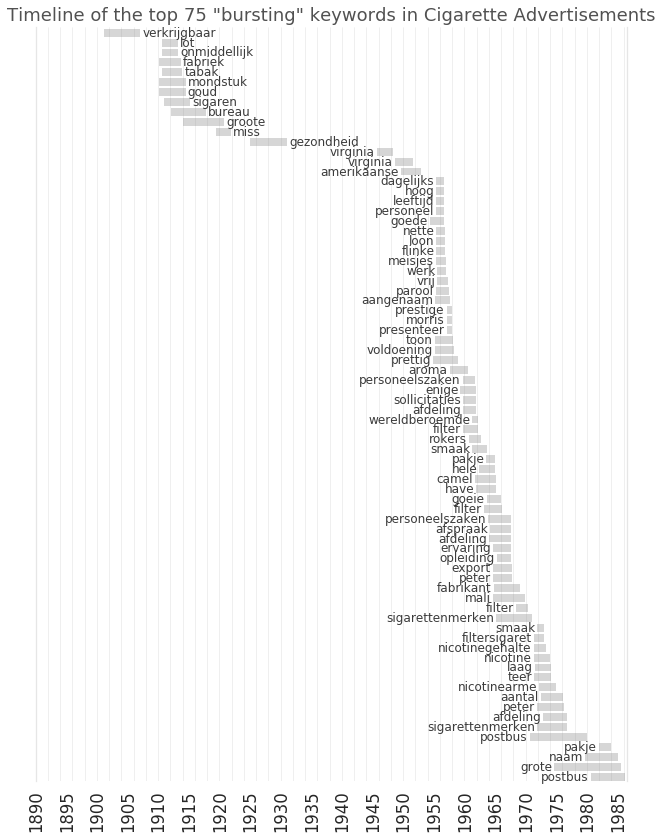

In [13]:
all_bursts2 = all_bursts[~all_bursts['label'].isin(remove_burst)]
#plot only the n biggest bursts
n_bursts = 75
top_bursts = all_bursts2.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]

#sort bursts by end date
sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
#for bursts that end at the last timepoint, sort by start point
last_timepoint = np.max(sorted_bursts['end'])
sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] \
                                                                         .sort_values(by='begin', ascending=False) \
                                                                         .reset_index(drop=True)
    
#format bars
bar_width = 0.8                                 #width of bars
bar_pos = np.array(range(len(sorted_bursts)))   #positions of top edge of bars
ylabel_pos = bar_pos + (bar_width/2)            #y axis label positions
n = len(d)                                      #number of time points

#initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 12))

#plot current bursts in blue and old bursts in gray
sorted_bursts['color'] = '#CCCCCC' #gray
#sorted_bursts.loc[sorted_bursts['end']==last_timepoint,'color'] = blog_blue

#plot the end points
end_bars = ax.barh(bar_pos, sorted_bursts.loc[:,'end'], bar_width, align='edge', 
        color=sorted_bursts['color'], edgecolor='none', alpha=.8)

#plot the start points (in white to blend in with the background)
start_bars = ax.barh(bar_pos, sorted_bursts.loc[:,'begin'], bar_width, align='edge', 
        color='w', edgecolor='none')

#label each burst
plt.yticks(ylabel_pos, '') #remove default labels
for burst in range(len(sorted_bursts)):
    width = int(end_bars[burst].get_width())
    #place label on right side for early bursts
    if width <= (n/2):
        plt.text(width+4, ylabel_pos[burst], sorted_bursts.loc[burst,'label'],
                fontsize=12, va='center', alpha=.9)
    #place label on left side for late bursts
    else:
        width = int(start_bars[burst].get_width())
        plt.text(width-4, ylabel_pos[burst], sorted_bursts.loc[burst,'label'],
                fontsize=12, va='center', ha='right', alpha=.9)
        
#format plot
ax.set(xlim=(0, n), ylim=(0,n_bursts+1), ylabel='', xlabel='')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_color([0.9, 0.9, 0.9])    
ax.spines["right"].set_color([0.9, 0.9, 0.9])
for x in range(0, n):
    if (x+1)%24 == 0:
        plt.axvline(x,color='gray', linestyle='-', linewidth=0.5, alpha=0.25)
plt.xticks(range(0,n+3,60),range(1890,1995,5),rotation='vertical')


ax.set_title('Timeline of the top ' + str(n_bursts) +' "bursting" keywords in Cigarette Advertisements', size=18, alpha=.8)
plt.tight_layout()
plt.savefig(os.path.join(figures_path, "bursts_top50.png"), bbox_inches="tight", dpi=300)